In [1]:
%load_ext autoreload
%autoreload 2

## Imports

In [2]:
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F

from factorization.data.synthetic import Sampler, SamplerConfig
from factorization.config import DEVICE
from factorization.models.mlp import ModelConfig, Model

from torch.utils.data import TensorDataset, DataLoader


torch.random.manual_seed(0)

## Data

Simple interface to generate all the data setup described in the overleaf

In [3]:
# %% Instantiation

alpha = 0.6
input_size = 60
output_size = 24

all_ps = [
    [3, 2, 2, 5],
    # [2, 6, 5],
    # [15, 2],
]

weights = None

sparse_config = SamplerConfig(
    input_divisors=all_ps,
    alpha=alpha,
    weights=weights,
    epsilon=1e-7,
)
sampler = Sampler(sparse_config).to(DEVICE)

deterministic_config = SamplerConfig(
    input_divisors=[[input_size]],
    output_divisors=[[output_size]],
    epsilon=1e-7,
)
deterministic_sampler = Sampler(deterministic_config).to(DEVICE)

random_config = SamplerConfig(
    input_size=input_size,
    output_size=output_size,
    random=True,
)
random_sampler = Sampler(random_config).to(DEVICE)

## Model

To keep it simple, I take a MLP architecture that resembles a transformer without attention.

In [4]:
config = ModelConfig(
    input_size=input_size,
    output_size=output_size,
    emb_dim=32,
    ffn_dim=64,
    nb_layers=2,
)


## training

In [43]:
n_epochs = 10000
learning_rate = 1e-3
zipf_coef = 2
train_proportion = .9
device=DEVICE

model = Model(config).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# define inputs, outputs, and a distribution over inputs
inputs = torch.arange(input_size).to(dtype=int, device=DEVICE)
targets = sampler.probas
input_probas = (inputs.float() + 1) ** (-zipf_coef)
input_probas /= input_probas.sum()

# define train and test samples
n_train = int(input_size * train_proportion)
indices = torch.randperm(len(inputs), device=DEVICE)
train_indices = indices[:n_train]
test_indices = indices[n_train:]

# placeholder
train_losses = torch.empty(n_epochs, device=DEVICE)
test_losses = torch.empty(n_epochs, device=DEVICE)
losses = torch.empty(n_epochs, device=DEVICE)

# compute minimum loss
all_loss = F.cross_entropy(torch.log(targets), targets, reduction='none')
min_loss = all_loss.mean().item()
all_loss *= input_probas
min_train_loss = all_loss[train_indices].sum().item()
min_test_loss = all_loss.sum().item() - min_train_loss

# training loop
model.train()
for epoch in range(n_epochs):
    logits = model(inputs)
    all_loss = F.cross_entropy(logits, targets, reduction='none')
    all_weighted_loss = all_loss * input_probas

    loss = all_weighted_loss[train_indices].sum()

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    with torch.no_grad():
        losses[epoch] = all_loss.sum() - min_loss
        train_losses[epoch] = loss - min_train_loss
        test_losses[epoch] = all_weighted_loss.sum() - loss - min_test_loss

In [42]:
train_losses_norm = train_losses / input_probas[train_indices].sum()
test_losses_norm = test_losses / input_probas[test_indices].sum()

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu!

[]

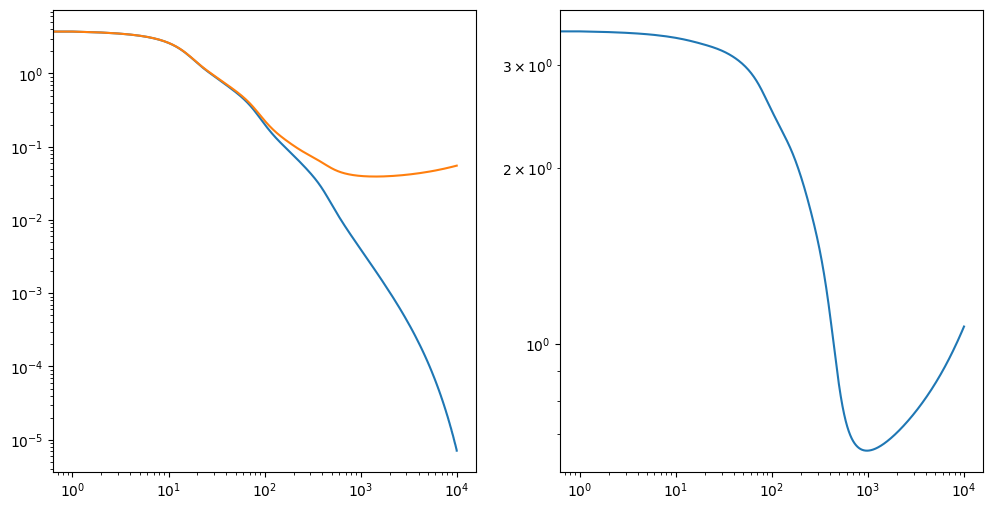

In [39]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].plot(train_losses[1:])
axes[0].plot(weighted_losses)
axes[1].plot(losses)
axes[0].loglog()
axes[1].loglog()

In [ ]:
len(test_loader)

1

In [ ]:
test_probas.argmax(dim=1)

tensor([23, 21, 20, 13, 15], device='cuda:0')

In [ ]:
len(test_probas)

5